In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [2]:
# Sækjum gögnin úr SkakgreinirGogn
import numpy as np

#leikir_heild = np.loadtxt("leikir_heild_50k.csv", delimiter=",", dtype=int, comments=None)
#leikir_sigurvegari = np.loadtxt("leikir_sigurvegari_50k.csv", delimiter=",", dtype=int, comments=None)
leikir_heild = np.loadtxt("/home/magnus/Documents/Skákgreinir_backup/leikir_heild.csv", delimiter=",", dtype=int, comments=None)
leikir_sigurvegari = np.loadtxt("leikir_sigurvegari.csv", delimiter=",", dtype=int, comments=None)

leikir_heild = leikir_heild[:300000]
leikir_sigurvegari = leikir_sigurvegari[:300000]

# Skoðum aðeins gögnin fyrir hvítann
leikir_heild_hvitur = []
leikir_sigurvegari_hvitur = []
nr_fyrri_leiks = 0
for i in range(leikir_heild.shape[0]):
    nr_nuverandi_leiks = leikir_heild[i,0]
    if nr_fyrri_leiks != nr_nuverandi_leiks:
        leikir_heild_hvitur.append(leikir_heild[i,:])
        leikir_sigurvegari_hvitur.append(leikir_sigurvegari[i])
    nr_fyrri_leiks = nr_nuverandi_leiks

#leikir_heild_hvitur = np.array(leikir_heild_hvitur[:200000])
#leikir_sigurvegari_hvitur = np.array(leikir_sigurvegari_hvitur[:200000])

# Skiptum gögnunum í training og test set
from sklearn.model_selection import train_test_split
#Xtr, Xts, ytr, yts = train_test_split(leikir_heild, leikir_sigurvegari, test_size=0.2, random_state=42)
Xtr, Xts, ytr, yts = train_test_split(leikir_heild_hvitur, leikir_sigurvegari_hvitur, test_size=0.2, random_state=42)

Xtr = np.array(Xtr)
Xts = np.array(Xts)
ytr = np.array(ytr)
yts = np.array(yts)

Xtr = torch.tensor(Xtr, device=device, dtype=torch.float)
ytr = torch.tensor(ytr, device=device, dtype=torch.long)
Xts = torch.tensor(Xts, device=device, dtype=torch.float)
yts = torch.tensor(yts, device=device, dtype=torch.long)

In [3]:
# Setjum gögnin á form sem hægt er að nota til að þjálfa netið
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128

train_data = TensorDataset(Xtr, ytr)
test_data = TensorDataset(Xts, yts)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
# Búum til uppsetninguna á tauganetinu
from torch import nn

n_in, n_out = len(leikir_heild[0,:]), 3
n_hid1, n_hid2, n_hid3 = 1000, 750, 500
#n_hid1, n_hid2, n_hid3, n_hid4 = 3000, 2000, 1000, 500
#n_hid1, n_hid2, n_hid3 = 1000, 500, 300
#n_hid1, n_hid2, n_hid3 = 100, 100, 100
#n_hid1, n_hid2 = 50, 50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_hid1, device=device)
        self.hidden2 = nn.Linear(n_hid1, n_hid2, device=device)
        self.hidden3 = nn.Linear(n_hid2, n_hid3, device=device)
        #self.hidden4 = nn.Linear(n_hid3, n_hid4, device=device)
        self.out = nn.Linear(n_hid3, n_out, device=device)
        self.relu = nn.SELU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        #x = self.relu(self.hidden4(x))
        x = self.softmax(self.out(x))
        return x

model = Net().to(device)
print(model)
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

Net(
  (hidden1): Linear(in_features=772, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=750, bias=True)
  (hidden3): Linear(in_features=750, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=3, bias=True)
  (relu): SELU()
  (softmax): Softmax(dim=1)
)
The model has 1,900,753 trainable parameters


In [5]:
# Setjum upp ítrunina
from sklearn.metrics import accuracy_score
num_epochs = 1000
train_accuracies, test_accuracies = [], []
train_loss, test_loss = [], []

learning_rate = 0.00001

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))
    train_accuracies.append(accuracy_score(ytr.cpu(), model(Xtr).argmax(1).cpu()))
    # Test
    model.eval()
    with torch.no_grad():
        y_pred = model(Xts)
        test_loss.append(loss_function(y_pred, yts).item())
        test_accuracies.append(accuracy_score(yts.cpu(), y_pred.argmax(1).cpu()))
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 1/1000, Training Loss: 0.8606, Test Loss: 0.8523, Test Accuracy: 0.6828, Training Accuracy: 0.6782
Epoch 2/1000, Training Loss: 0.8579, Test Loss: 0.8510, Test Accuracy: 0.6843, Training Accuracy: 0.6787
Epoch 3/1000, Training Loss: 0.8571, Test Loss: 0.8514, Test Accuracy: 0.6854, Training Accuracy: 0.6796
Epoch 4/1000, Training Loss: 0.8570, Test Loss: 0.8521, Test Accuracy: 0.6819, Training Accuracy: 0.6785
Epoch 5/1000, Training Loss: 0.8557, Test Loss: 0.8545, Test Accuracy: 0.6820, Training Accuracy: 0.6784
Epoch 6/1000, Training Loss: 0.8550, Test Loss: 0.8489, Test Accuracy: 0.6883, Training Accuracy: 0.6816
Epoch 7/1000, Training Loss: 0.8542, Test Loss: 0.8504, Test Accuracy: 0.6829, Training Accuracy: 0.6794
Epoch 8/1000, Training Loss: 0.8549, Test Loss: 0.8492, Test Accuracy: 0.6882, Training Accuracy: 0.6809
Epoch 9/1000, Training Loss: 0.8533, Test Loss: 0.8536, Test Accuracy: 0.6807, Training Accuracy: 0.6770
Epoch 10/1000, Training Loss: 0.8544, Test Loss: 0.8508

In [6]:
# from sklearn.metrics import accuracy_score
# num_epochs = 30
# train_accuracies, test_accuracies = [], []
# train_loss, test_loss = [], []

# learning_rate = 0.001
# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     # Train set
#     for X, y in train_loader:        
#         # Forward
#         y_pred = model(X)
#         y_pred_labels = torch.argmax(y_pred, axis=1)
#         loss = loss_function(y_pred_labels, y)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     train_accuracies.append(accuracy_score(ytr.cpu(), torch.argmax(model(Xtr), axis=1).cpu()))
#     train_loss.append(loss.item())
    
#     # Test set
#     X, y = next(iter(test_loader))
#     #y = y.type(torch.LongTensor).to(device)
#     y_pred_labels = torch.argmax(model(X), axis=1)
#     test_accuracies.append(accuracy_score(yts.cpu(), torch.argmax(model(Xts), axis=1).cpu()))
#     test_loss.append(loss_function(model(X), y).item())

Text(0.5, 0, 'Ítranir')

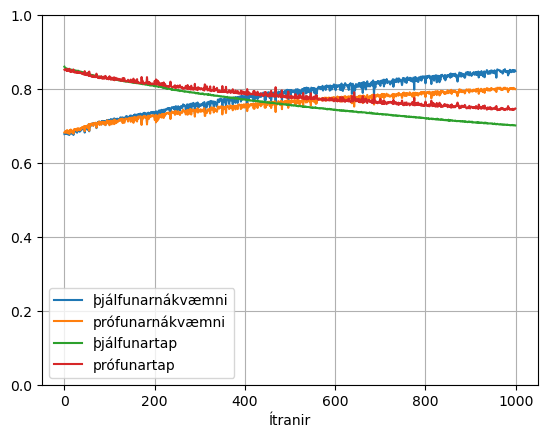

In [7]:
# Sýnum niðurstöður
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='þjálfunarnákvæmni')
plt.plot(test_accuracies, label='prófunarnákvæmni')
plt.plot(train_loss, label='þjálfunartap')
plt.plot(test_loss, label='prófunartap')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Ítranir')

In [8]:
# The size of the list leikir_heild_hvitur
print(len(leikir_heild_hvitur))

151274


In [9]:
# Búum til uppsetninguna á tauganetinu
from torch import nn

n_in, n_out = len(leikir_heild[0,:]), 3
#n_hid1, n_hid2, n_hid3, n_hid4 = 3000, 2000, 1000, 500
#n_hid1, n_hid2, n_hid3 = 1000, 500, 300
#n_hid1, n_hid2, n_hid3 = 100, 100, 100
n_hid1, n_hid2 = 50, 50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_hid1, device=device)
        self.hidden2 = nn.Linear(n_hid1, n_hid2, device=device)
        #self.hidden3 = nn.Linear(n_hid2, n_hid3, device=device)
        #self.hidden4 = nn.Linear(n_hid3, n_hid4, device=device)
        self.out = nn.Linear(n_hid2, n_out, device=device)
        self.relu = nn.SELU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        #x = self.relu(self.hidden3(x))
        #x = self.relu(self.hidden4(x))
        x = self.softmax(self.out(x))
        return x

model = Net().to(device)
print(model)
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

Net(
  (hidden1): Linear(in_features=772, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=3, bias=True)
  (relu): SELU()
  (softmax): Softmax(dim=1)
)
The model has 41,353 trainable parameters


In [10]:
# Setjum upp ítrunina
from sklearn.metrics import accuracy_score
num_epochs = 1000
train_accuracies, test_accuracies = [], []
train_loss, test_loss = [], []

learning_rate = 0.00001

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))
    train_accuracies.append(accuracy_score(ytr.cpu(), model(Xtr).argmax(1).cpu()))
    # Test
    model.eval()
    with torch.no_grad():
        y_pred = model(Xts)
        test_loss.append(loss_function(y_pred, yts).item())
        test_accuracies.append(accuracy_score(yts.cpu(), y_pred.argmax(1).cpu()))
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 1/1000, Training Loss: 0.8836, Test Loss: 0.8525, Test Accuracy: 0.6841, Training Accuracy: 0.6785
Epoch 2/1000, Training Loss: 0.8561, Test Loss: 0.8519, Test Accuracy: 0.6847, Training Accuracy: 0.6787
Epoch 3/1000, Training Loss: 0.8557, Test Loss: 0.8516, Test Accuracy: 0.6846, Training Accuracy: 0.6787
Epoch 4/1000, Training Loss: 0.8554, Test Loss: 0.8516, Test Accuracy: 0.6857, Training Accuracy: 0.6789
Epoch 5/1000, Training Loss: 0.8553, Test Loss: 0.8518, Test Accuracy: 0.6820, Training Accuracy: 0.6776
Epoch 6/1000, Training Loss: 0.8551, Test Loss: 0.8514, Test Accuracy: 0.6833, Training Accuracy: 0.6786
Epoch 7/1000, Training Loss: 0.8549, Test Loss: 0.8511, Test Accuracy: 0.6850, Training Accuracy: 0.6791
Epoch 8/1000, Training Loss: 0.8549, Test Loss: 0.8510, Test Accuracy: 0.6856, Training Accuracy: 0.6791
Epoch 9/1000, Training Loss: 0.8547, Test Loss: 0.8510, Test Accuracy: 0.6864, Training Accuracy: 0.6796
Epoch 10/1000, Training Loss: 0.8546, Test Loss: 0.8508

KeyboardInterrupt: 

Text(0.5, 0, 'Ítranir')

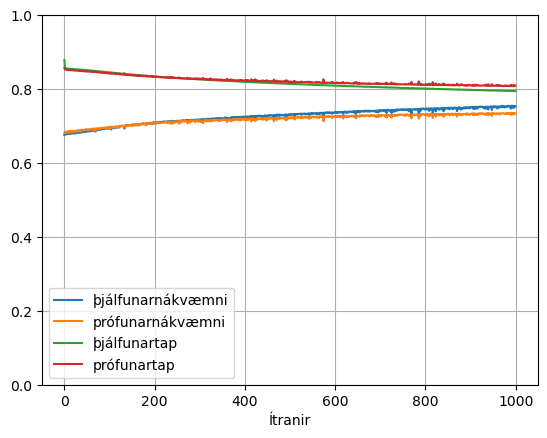

In [ ]:
# Sýnum niðurstöður
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='þjálfunarnákvæmni')
plt.plot(test_accuracies, label='prófunarnákvæmni')
plt.plot(train_loss, label='þjálfunartap')
plt.plot(test_loss, label='prófunartap')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Ítranir')